# Import statements


In [ ]:
import os
import time
import keras
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import adam_v2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Flatten, ZeroPadding2D, BatchNormalization, InputLayer, Activation

Start time 

In [ ]:
Start = time.time()

# Constants Declaration

In [ ]:
HeightCNN = 240
WidthCNN = 240

HeightVGG = 224
WidthVGG = 224

TumorImage = 1085
NonTumorImage = 980

TestingTumor = 175
TestingNonTumor = 135

ValidationTumor = 152
ValidationNonTumor = 158

Epoch = 25

# Preprocessing

## Geting filenames and their classes

In [ ]:
Df = pd.DataFrame()
for i in os.listdir("/content/drive/MyDrive/Brai MRI datasets/1/no"):
  Df = Df.append({"filename": "/content/drive/MyDrive/Brai MRI datasets/1/no/" + i, "class": "No"}, ignore_index = True)
for i in os.listdir("/content/drive/MyDrive/Brai MRI datasets/1/yes"):
  Df = Df.append({"filename": "/content/drive/MyDrive/Brai MRI datasets/1/yes/" + i, "class": "Yes"}, ignore_index = True)

## Augmentation


### Creating an image generator for Augmentation


In [ ]:
train_datagen = ImageDataGenerator(rotation_range=5,
                                   width_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   brightness_range=[0.2,0.8]) 
Generator = train_datagen.flow_from_dataframe(Df,
                                              class_mode="binary", 
                                              target_size=(HeightVGG,HeightVGG),
                                              color_mode = "rgb", 
                                              batch_size=1,
                                              rescale=1.0/255)

Found 253 validated image filenames belonging to 2 classes.


### Getting images data from Image generator based on our needs

In [ ]:
AugmentedDf = pd.DataFrame()
while TumorImage != 0 or NonTumorImage != 0:
  image,Type = next(Generator)
  image = image.astype('uint8')
  image = np.squeeze(image)
  if Type == Generator.class_indices['Yes'] and TumorImage != 0:
    TumorImage -= 1
    AugmentedDf = AugmentedDf.append({"Image224X224": image, "class": "Yes"}, ignore_index = True)
  if Type == Generator.class_indices['No'] and NonTumorImage != 0:
    NonTumorImage -= 1
    AugmentedDf = AugmentedDf.append({"Image224X224": image, "class": "No"}, ignore_index = True)

### Label encoding classes to integer

In [ ]:
Encoder = LabelEncoder()
AugmentedDf["class"] = Encoder.fit_transform(AugmentedDf["class"])

#### Checking the values in the dataframe

In [ ]:
AugmentedDf.head(),AugmentedDf.shape

(                                        Image224X224  class
 0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1
 1  [[[10, 10, 10], [8, 8, 8], [6, 6, 6], [5, 5, 5...      1
 2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1
 3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1
 4  [[[14, 14, 14], [14, 14, 14], [14, 14, 14], [1...      1, (2065, 2))

## Eroding and dilating the images (making the image blur)

### Eroding and dilating (function)

In [ ]:
def Erosion_Dilation(src):
  kernel = np.ones((5,5), np.uint8)  
  return cv.dilate(cv.erode(src,kernel,iterations=1) , kernel,iterations=1) 

### Eroding and dilating the images in the dataframe

In [ ]:
AugmentedDf.Image224X224 = AugmentedDf.Image224X224.apply(Erosion_Dilation)

#### Visualization of the processed data

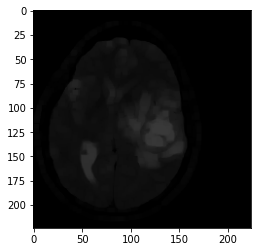

In [ ]:
plt.imshow(AugmentedDf.Image224X224[0])

In [ ]:
AugmentedDf.Image224X224[0].shape

(224, 224, 3)

## Contouring and resizing the image

### Countouring and resizing(function)

In [ ]:
def Contour(src,Dim):
  UpperBoundary = 255
  LowerBoundary = 20
  
  src = cv.resize(src,Dim)
  Lower = np.array(LowerBoundary, dtype="uint8")
  Upper = np.array(UpperBoundary, dtype="uint8")
  mask = cv.inRange(src, Lower, Upper)
  output = cv.bitwise_and(src, src, mask=mask)

  ret,thresh = cv.threshold(mask, 40, 255, 0)
  contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
  if len(contours) != 0:
    c = max(contours, key = cv.contourArea)
    x,y,w,h = cv.boundingRect(c)
    cv.rectangle(output,(x,y),(x+w,y+h),(255,255,255),1)
    return cv.resize(src[y:y+h,x:x+w],Dim)
  return src


#### Visualizing the images after and before contour, resizing

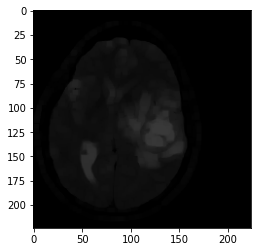

In [ ]:
plt.imshow(AugmentedDf.Image224X224[0])

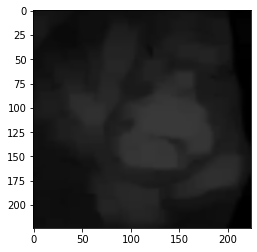

In [ ]:
plt.imshow(Contour(AugmentedDf.Image224X224[0],(HeightVGG,WidthVGG)))

### Creating contour images of (224x224) for VGG and (224x224) for CNN


In [ ]:
AugmentedDf.Image224X224 = AugmentedDf.Image224X224.apply(Contour,args=((HeightVGG,WidthVGG),))
AugmentedDf["Image240X240"] = AugmentedDf.Image224X224.apply(Contour,args=((HeightCNN,WidthCNN),))

### Reordering the columns in the dataset

In [ ]:
AugmentedDf = AugmentedDf[["Image240X240","Image224X224","class"]]

#### Visualizing the columns changes

In [ ]:
AugmentedDf.head()

,Image240X240,Image224X224,class
0,"[[[17, 17, 17], [17, 17, 17], [18, 18, 18], [1...","[[[17, 17, 17], [17, 17, 17], [18, 18, 18], [1...",1
1,"[[[5, 5, 5], [5, 5, 5], [5, 5, 5], [5, 5, 5], ...","[[[5, 5, 5], [5, 5, 5], [5, 5, 5], [5, 5, 5], ...",1
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
4,"[[[11, 11, 11], [11, 11, 11], [11, 11, 11], [1...","[[[11, 11, 11], [11, 11, 11], [11, 11, 11], [1...",1


## Split

### Creating the Train,Test,Validate split based on the given count

In [ ]:
TrainingDf = pd.DataFrame()
ValidationDf = pd.DataFrame()
TestingDf = pd.DataFrame()

for i in AugmentedDf.index:
  if TestingTumor != 0 and AugmentedDf['class'][i] == 1:
    TestingTumor -= 1
    TestingDf  = TestingDf.append(AugmentedDf.iloc[i],verify_integrity=True, ignore_index = True)
  elif TestingNonTumor != 0 and AugmentedDf['class'][i] == 0:
    TestingNonTumor -= 1
    TestingDf  = TestingDf.append(AugmentedDf.iloc[i],verify_integrity=True, ignore_index = True)
  elif ValidationTumor != 0 and AugmentedDf['class'][i] == 1:
    ValidationTumor -= 1
    ValidationDf  = ValidationDf.append(AugmentedDf.iloc[i],verify_integrity=True, ignore_index = True)
  elif ValidationNonTumor != 0 and AugmentedDf['class'][i] == 0:
    ValidationNonTumor -= 1
    ValidationDf  = ValidationDf.append(AugmentedDf.iloc[i],verify_integrity=True, ignore_index = True)
  else:
    TrainingDf = TrainingDf.append(AugmentedDf.iloc[i],verify_integrity=True, ignore_index = True)


#### Visualizing the shape of train,test and validate dataframe

In [ ]:
TrainingDf.shape,TestingDf.shape,ValidationDf.shape

((1445, 3), (310, 3), (310, 3))

### Shuffling the rows in the train,test and validate dataframe

In [ ]:
TrainingDf = TrainingDf.sample(frac = 1)
TestingDf = TestingDf.sample(frac = 1)
ValidationDf = ValidationDf.sample(frac = 1)

## Numpy to tensor converter

### Numpy to tensor converting(function)

In [ ]:
def CNN_Formatter(X,Y):
  return tf.convert_to_tensor(list(X)),tf.convert_to_tensor(list(Y))

### Converting and creating tensor iterator for model

In [ ]:
X_CNN , Y_CNN = CNN_Formatter(TrainingDf.Image240X240,TrainingDf["class"])
X_CNN_Val,Y_CNN_Val = CNN_Formatter(ValidationDf.Image240X240,ValidationDf["class"])
X_CNN_Test,Y_CNN_Test = CNN_Formatter(TestingDf.Image240X240,TestingDf["class"])

# Model

## CNN Model

### CNN Sequential model

In [ ]:
ModelCNN = Sequential()
ModelCNN.add(InputLayer(input_shape=(HeightCNN,WidthCNN,3)))
ModelCNN.add(ZeroPadding2D(padding=(2,2)))
ModelCNN.add(Conv2D(filters=32,kernel_size=(7,7)))
ModelCNN.add(BatchNormalization())
ModelCNN.add(Activation(activation='relu'))
ModelCNN.add(MaxPooling2D(pool_size=(4,4),strides=4))
ModelCNN.add(MaxPooling2D(pool_size=(4,4),strides=4))
ModelCNN.add(Flatten())
ModelCNN.add(Dense(units=1))

### CNN Model summary

In [ ]:
ModelCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 238, 238, 32)      4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

### CNN model Compile

In [ ]:
ModelCNN.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

### CNN model fit

In [ ]:
ModelCNN.fit(x = X_CNN,y = Y_CNN,epochs=Epoch, validation_data=(X_CNN_Val,Y_CNN_Val),batch_size=10)

Epoch 1/25
145/145 [==============================] - 36s 35ms/step - loss: 0.7116 - accuracy: 0.6256 - val_loss: 0.6074 - val_accuracy: 0.6903
Epoch 2/25
145/145 [==============================] - 4s 31ms/step - loss: 0.5658 - accuracy: 0.7218 - val_loss: 0.6224 - val_accuracy: 0.7194
Epoch 3/25
145/145 [==============================] - 4s 31ms/step - loss: 0.5132 - accuracy: 0.7661 - val_loss: 0.5373 - val_accuracy: 0.7258
Epoch 4/25
145/145 [==============================] - 4s 31ms/step - loss: 0.4355 - accuracy: 0.7965 - val_loss: 0.4833 - val_accuracy: 0.7452
Epoch 5/25
145/145 [==============================] - 5s 31ms/step - loss: 0.3714 - accuracy: 0.8256 - val_loss: 0.5316 - val_accuracy: 0.7645
Epoch 6/25
145/145 [==============================] - 5s 31ms/step - loss: 0.3635 - accuracy: 0.8381 - val_loss: 0.5047 - val_accuracy: 0.7871
Epoch 7/25
145/145 [==============================] - 4s 31ms/step - loss: 0.3403 - accuracy: 0.8429 - val_loss: 0.5689 - val_accuracy: 0.712

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f062b84cb00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


### CNN model evaluate

In [ ]:
ModelCNN.evaluate(X_CNN_Test,Y_CNN_Test,batch_size=10)

31/31 [==============================] - 1s 16ms/step - loss: 0.4809 - accuracy: 0.8677


[0.48093125224113464, 0.8677419424057007]

In [ ]:
End = time.time()
Diff = End - Start
print(f"Runtime of the program is {End - Start}")

Runtime of the program is 521.4077613353729


## VGG Model

### VGG Sequential model

In [ ]:
ModelVGG = Sequential()
ModelVGG.add(InputLayer(input_shape=(HeightVGG,WidthVGG,3)))
ModelVGG.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
ModelVGG.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
ModelVGG.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
ModelVGG.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
ModelVGG.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
ModelVGG.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
ModelVGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
ModelVGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
ModelVGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
ModelVGG.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
ModelVGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
ModelVGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
ModelVGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
ModelVGG.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
ModelVGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
ModelVGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
ModelVGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
ModelVGG.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
ModelVGG.add(Flatten())
ModelVGG.add(Dense(units=4096,activation="relu"))
ModelVGG.add(Dense(units=4096,activation="relu"))
ModelVGG.add(Dense(units=2, activation="softmax"))


### VGG Model summary

In [ ]:
ModelVGG.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)      

### VGG model compile

In [ ]:
sgd = tf.optimizers.SGD(learning_rate=0.1, decay=1e-6, momentum=0.9, nesterov=True)
ModelVGG.compile(optimizer=sgd, loss='categorical_crossentropy',metrics=['accuracy'])

### VGG model fit

In [ ]:
def VGG_Formatter(X,Y):
  Encoder = OneHotEncoder(sparse=False)
  Y = np.array(Y)
  
  return tf.convert_to_tensor(list(X)),tf.convert_to_tensor(list(Encoder.fit_transform(Y.reshape(-1,1))))

In [ ]:
X_VGG , Y_VGG = VGG_Formatter(TrainingDf.Image224X224,TrainingDf["class"])
X_VGG_Val,Y_VGG_Val = VGG_Formatter(ValidationDf.Image224X224,ValidationDf["class"])
X_VGG_Test,Y_VGG_Test = VGG_Formatter(TestingDf.Image224X224,TestingDf["class"])

In [ ]:
Y_VGG.shape

TensorShape([1445, 2])

In [37]:
ModelVGG.fit(x = X_VGG,y = Y_VGG,epochs=Epoch, validation_data=(X_VGG_Val,Y_VGG_Val),batch_size=10)

Epoch 1/25
145/145 [==============================] - 67s 415ms/step - loss: 125432466885312512.0000 - accuracy: 0.4886 - val_loss: 0.6935 - val_accuracy: 0.4903
Epoch 2/25
145/145 [==============================] - 58s 399ms/step - loss: 0.7011 - accuracy: 0.5156 - val_loss: 0.7011 - val_accuracy: 0.5097
Epoch 3/25
145/145 [==============================] - 56s 389ms/step - loss: 0.7010 - accuracy: 0.4997 - val_loss: 0.7028 - val_accuracy: 0.4903
Epoch 4/25
145/145 [==============================] - 58s 398ms/step - loss: 0.7035 - accuracy: 0.4983 - val_loss: 0.7540 - val_accuracy: 0.4903
Epoch 5/25
145/145 [==============================] - 58s 399ms/step - loss: 0.7009 - accuracy: 0.5107 - val_loss: 0.7135 - val_accuracy: 0.4903
Epoch 6/25
145/145 [==============================] - 56s 388ms/step - loss: 0.6977 - accuracy: 0.5197 - val_loss: 0.6931 - val_accuracy: 0.5097
Epoch 7/25
145/145 [==============================] - 58s 399ms/step - loss: 0.7028 - accuracy: 0.4886 - val_loss

### VGG model evaluate


In [38]:
ModelVGG.evaluate(X_VGG_Test,Y_VGG_Test,batch_size=10)

31/31 [==============================] - 4s 122ms/step - loss: 0.6984 - accuracy: 0.4355


[0.6983739733695984, 0.4354838728904724]

In [39]:
End = time.time()

In [40]:
End = time.time()
print(f"Runtime of the program is {End - Start - Diff}")

Runtime of the program is 1613.025642156601
